In [1]:
import os, pickle
from Moments_analysis import Compute_moments as cm
import numpy as np

In [ ]:
fils = os.listdir("/global/cfs/cdirs/des/mgatti/Dirac/LFI_dv/peaks_th/")
print(fils[0])
with open("/global/cfs/cdirs/des/mgatti/Dirac/LFI_dv/peaks_th/"+fils[0], "rb") as f:
    p = pickle.load(f)
    print(p)

shear_maps_runsM_run015_nside512_noiserel3_rel1.pkl
[<Moments_analysis.Compute_moments.moments_map object at 0x7f937c28eb20>, {'om': 0.4210278998052078, 'h': 0.7053694105635738, 's8': 0.47258038315673057, 'w': -0.7676645983654508, 'ob': 0.04480913801053, 'ns': 0.9614860595209705, 'm': array([1.00481857, 0.99235748, 0.98685673, 0.9665764 ]), 'hyperrank_rel': 2950, 'A_IA': -2.49785, 'E_IA': 1.48502}]


In [ ]:
def read_peaks(m_):
    count = 0
    for t in m_.peaks['k_sm_kE'].keys():
        for sc in m_.peaks['k_sm_kE'][t].keys():
            if count == 0:
                dv = (m_.peaks['k_sm_kE'][t][sc]-m_.peaks['kn_sm_kE'][t][sc]) 
                tomo    = t*np.ones(len(m_.peaks['k_sm_kE'][t][sc]))
                filters = sc*np.ones(len(m_.peaks['k_sm_kE'][t][sc]))
                scales = m_.peaks['k_sm_kE'][t][sc]
                
            else:
                dv = np.hstack([dv,(m_.peaks['k_sm_kE'][t][sc]-m_.peaks['kn_sm_kE'][t][sc]) ])
                tomo_    = t*np.ones(len(m_.peaks['k_sm_kE'][t][sc]))
                filters_ = sc*np.ones(len(m_.peaks['k_sm_kE'][t][sc]))

                tomo = np.hstack([tomo,tomo_])
                filters = np.hstack([filters,filters_])

                scales = np.hstack([scales,m_.peaks['k_sm_kE'][t][sc]])
            count +=1
    return dv,filters,scales,tomo

In [ ]:
[x.shape for x in read_peaks(p[0])], read_peaks(p[0])

([(1120,), (1120,), (1120,), (1120,)],
 (array([ 35,   7, -77, ..., 248, 164, 117]),
  array([  8.2,   8.2,   8.2, ..., 221. , 221. , 221. ]),
  array([ 257,  725, 1565, ...,  309,  188,  130]),
  array([ 0.,  0.,  0., ..., 32., 32., 32.])))

In [ ]:
import glob
import os
from Moments_analysis import moments_map
import numpy as np
import gc
import pickle
import healpy as hp
import sys
import shutil
def save_obj(name, obj):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, protocol=2)
        f.close()

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        mute =  pickle.load(f)
        f.close()
    return mute



def g2k_sphere(gamma1, gamma2, mask, nside=1024, lmax=2048,nosh=True):
    """
    Convert shear to convergence on a sphere. In put are all healpix maps.
    """

    gamma1_mask = gamma1 * mask
    gamma2_mask = gamma2 * mask

    KQU_masked_maps = [gamma1_mask, gamma1_mask, gamma2_mask]
    alms = hp.map2alm(KQU_masked_maps, lmax=lmax, pol=True)  # Spin transform!


    ell, emm = hp.Alm.getlm(lmax=lmax)
    if nosh:
        almsE = alms[1] * 1. * ((ell * (ell + 1.)) / ((ell + 2.) * (ell - 1))) ** 0.5
        almsB = alms[2] * 1. * ((ell * (ell + 1.)) / ((ell + 2.) * (ell - 1))) ** 0.5
    else:
        almsE = alms[1] * 1.
        almsB = alms[2] * 1. 
    almsE[ell == 0] = 0.0
    almsB[ell == 0] = 0.0
    almsE[ell == 1] = 0.0
    almsB[ell == 1] = 0.0



    almssm = [alms[0], almsE, almsB]


    kappa_map_alm = hp.alm2map(almssm[0], nside=nside, lmax=lmax, pol=False)
    E_map = hp.alm2map(almssm[1], nside=nside, lmax=lmax, pol=False)
    B_map = hp.alm2map(almssm[2], nside=nside, lmax=lmax, pol=False)

    return E_map, B_map, almsE, almsB

def compute_phmoments(file,output=''):
      

        
        dict_temp = np.load(file,allow_pickle=True).item()
# 

        target = file.split('/global/cfs/cdirs/des/mgatti/Dirac_mocks/')[1].split('.npy')[0]

            
            
        mock = target.split('runs')[1].split('_')[0]
        run = int(target.split('run')[2].split('_')[0])
        f = open(('/global/u2/m/mgatti/Mass_Mapping/peaks/params_run_1_Niall_{0}.txt'.format(mock)),'r')
        om_ = []
        h_ = []
        ns_ = []
        ob_ = []
        s8_ = []
        w_ = []
        for i,f_ in enumerate(f):
            if i>0:
                om_.append(float(f_.split(',')[0]))
                h_.append(float(f_.split(',')[4]))
                ns_.append(float(f_.split(',')[5]))
                ob_.append(float(f_.split(',')[3]))
                s8_.append(float(f_.split(',')[1]))
                w_.append(float(f_.split(',')[2]))
            else:
                print (f_)


        for rel in range(4):
            params = dict()
            params['om'] = om_[run-1]
            params['h'] = h_[run-1]
            params['s8'] = s8_[run-1]
            params['w'] = w_[run-1]
            params['ob'] = ob_[run-1]
            params['ns'] = ns_[run-1]
            for k in dict_temp[rel]['nuisance_params'].keys():
                params[k] = dict_temp[rel]['nuisance_params'][k]

            
            if not os.path.exists(output+target+'_rel{0}'.format(rel)+'.pkl'):

                conf = dict()
                conf['J_min'] = 5
                conf['B'] = 2
                conf['nside'] = 512
                conf['lmax'] = conf['nside']*2
                conf['verbose'] = False
                conf['neighbour_pixels'] = '/global/cfs/cdirs/des/mgatti/Dirac/neighbours_512'
                conf['output_folder'] = output_intermediate+'/test_'+target+'_rel{0}'.format(rel)

                conf['smoothing_scales'] = np.array([8.2,13.1,21.0,33.6,54.,86.,138,221.])


                mcal_moments = moments_map(conf)
                    
                ex = np.load('/global/cfs/cdirs/des/mgatti/pywph_results/peaks_data_extrema.npy',allow_pickle=True).item()
                mcal_moments.conf['kappa_bin']  = dict()
                for sm in conf['smoothing_scales'] :
                    conf['kappa_bin'][sm] = dict()
                    for t in [0,1,2,3,10,20,21,30,31,32]:
                        conf['kappa_bin'][sm][t] =  np.linspace(ex[t][sm][0],ex[t][sm][1],15)


        
               
                #mask_DES_y3 = load_obj('/global/cfs/cdirs/des//mass_maps/Maps_final//mask_DES_y3')

                #mask_DES_y3
                # this add the maps
                tomo_bins = [0,1,2,3] #0,1,2,3]
                almsB_ = []
                almsE_ = []
                almsBN_ = []
                almsEN_ = []
                for t in tomo_bins:
                    
                    e1 = np.zeros(hp.nside2npix(conf['nside']))
                    e2 = np.zeros(hp.nside2npix(conf['nside']))
                    e1n = np.zeros(hp.nside2npix(conf['nside']))
                    e2n = np.zeros(hp.nside2npix(conf['nside']))
                    e1[dict_temp[rel][t+1]['pix']] = dict_temp[rel][t+1]['e1']
                    e2[dict_temp[rel][t+1]['pix']] = dict_temp[rel][t+1]['e2']
                    e1n[dict_temp[rel][t+1]['pix']] = dict_temp[rel][t+1]['e1n']
                    e2n[dict_temp[rel][t+1]['pix']] = dict_temp[rel][t+1]['e2n']
                    
                    mask_sims = np.in1d(np.arange(len(e1)),dict_temp[rel][t+1]['pix'])
     
                    f,fb,almsE , almsB   =  g2k_sphere(e1,e2, mask_sims, nside=conf['nside'], lmax=conf['nside']*2 ,nosh=True)
                    fn,fbn, almsEN , almsBN  =  g2k_sphere(e1n,e2n, mask_sims, nside=conf['nside'], lmax=conf['nside']*2 ,nosh=True)

                    almsB_.append(almsB)
                    almsE_.append(almsE)
                    almsBN_.append(almsBN)
                    almsEN_.append(almsEN)

                    
                    mcal_moments.add_map(f, field_label = 'k', tomo_bin = t)
                    mcal_moments.add_map(fn, field_label = 'kn', tomo_bin = t)
                    mcal_moments.add_map(fb, field_label = 'bk', tomo_bin = t)
                    mcal_moments.add_map(fbn, field_label = 'bkn', tomo_bin = t)
                    
                    
                    if t == 3:
                        mcal_moments.mask = mask_sims 
                       # mcal_moments.mask = dict_temp[rel][t+1]['mask'] 
      
                for t1 in tomo_bins:
                    for t2 in tomo_bins:
                        if t1>t2:
                            kE = hp.alm2map(almsE_[t1]*almsE_[t2], nside=conf['nside'], lmax=conf['nside']*2, pol=False)
                            kB = hp.alm2map(almsB_[t1]*almsB_[t2], nside=conf['nside'], lmax=conf['nside']*2, pol=False)
                            kEN = hp.alm2map(almsEN_[t1]*almsEN_[t2], nside=conf['nside'], lmax=conf['nside']*2, pol=False)
                            kBN = hp.alm2map(almsBN_[t1]*almsBN_[t2], nside=conf['nside'], lmax=conf['nside']*2, pol=False)
                            mcal_moments.add_map(kE, field_label = 'k', tomo_bin = 10*t1+t2)
                            mcal_moments.add_map(kB, field_label = 'bk', tomo_bin = 10*t1+t2)
                            mcal_moments.add_map(kEN, field_label = 'kn', tomo_bin = 10*t1+t2)
                            mcal_moments.add_map(kBN, field_label = 'bkn', tomo_bin = 10*t1+t2)



                mcal_moments.transform_and_smooth(output_label = 'k_sm', field_label1 = 'k', shear = False, tomo_bins = [0,1,2,3,10,20,21,30,31,32])
                mcal_moments.transform_and_smooth(output_label = 'kn_sm', field_label1 = 'kn', shear = False, tomo_bins = [0,1,2,3,10,20,21,30,31,32])

                #mcal_moments.conf['kappa_bin']  = np.linspace(-0.0002,0.0035,25)
                #mcal_moments.conf['kappa_bin_cross']  = np.linspace(-1e-9,1e-7,25)
                #mcal_moments.transform_and_smooth_sp(output_label = 'k_sm', field_label1 = 'k', shear = False, tomo_bins = [0,1,2,3,10,20,21,30,31,32])
               ## mcal_moments.transform_and_smooth_sp(output_label = 'kn_sm', field_label1 = 'kn', shear = False, tomo_bins = [0,1,2,3,10,20,21,30,31,32])
                del mcal_moments.fields
                gc.collect()
                mcal_moments.compute_peaks(field_label = 'k_sm_kE')
                mcal_moments.compute_peaks(field_label = 'kn_sm_kE')
           
                del mcal_moments.smoothed_maps
                gc.collect()
                save_obj(output+target+'_rel{0}'.format(rel),[mcal_moments,params])
                shutil.rmtree( output_intermediate+'/test_'+target+'_rel{0}'.format(rel))


In [ ]:
output_intermediate = '/pscratch/sd/s/shubh/graph_data/temp/'
files = glob.glob('/global/cfs/cdirs/des/mgatti/Dirac_mocks/*')
output = '/pscratch/sd/s/shubh/graph_data/temp_out/'
f_= []
for f in files:
    try:
        xx = int(f.split('noiserel')[1].split('.npy')[0])

        if ('512' in f) :
            f_.append(f)
    except:
        pass
runstodo = []
count = 0
for f in f_:
        target = f.split('/global/cfs/cdirs/des/mgatti/Dirac_mocks/')[1].split('.npy')[0]
    #if ('_noiserel6' in f) or ('_noiserel7' in f) or ('_noiserel8' in f):
    
        if not os.path.exists(output+target+'_rel3.pkl'):
            # if ('noiserel31' in target) or ('noiserel32' in target):
            runstodo.append(f)
        else:
            count +=1

NameError: name 'glob' is not defined

In [ ]:
compute_phmoments(runstodo[0],output)

# Omega_m, sigma_8, w, Omega_b, little_h, n_s, m_nu



/tmp/ipykernel_23463/3958607932.py:37: RuntimeWarning: divide by zero encountered in divide
  almsE = alms[1] * 1. * ((ell * (ell + 1.)) / ((ell + 2.) * (ell - 1))) ** 0.5
/tmp/ipykernel_23463/3958607932.py:37: RuntimeWarning: invalid value encountered in multiply
  almsE = alms[1] * 1. * ((ell * (ell + 1.)) / ((ell + 2.) * (ell - 1))) ** 0.5
/tmp/ipykernel_23463/3958607932.py:38: RuntimeWarning: divide by zero encountered in divide
  almsB = alms[2] * 1. * ((ell * (ell + 1.)) / ((ell + 2.) * (ell - 1))) ** 0.5
/tmp/ipykernel_23463/3958607932.py:38: RuntimeWarning: invalid value encountered in multiply
  almsB = alms[2] * 1. * ((ell * (ell + 1.)) / ((ell + 2.) * (ell - 1))) ** 0.5


KeyboardInterrupt: 

In [1]:
import os, pickle
from Moments_analysis import Compute_moments as cm
import numpy as np
import healpy as hp
from matplotlib import pyplot as plt
import scipy.ndimage as ndimage

In [2]:
os.listdir("/pscratch/sd/s/shubh/graph_data/dirac/")[:10], os.listdir("/global/cfs/cdirs/des/mgatti/Dirac/LFI_dv/peaks_th/")[:10]

(['shear_maps_runsI_run086_nside512_noiserel10_rel0.pkl',
  'shear_maps_runsQ_run027_nside512_noiserel0_rel0.pkl',
  'shear_maps_runsS_run005_nside512_noiserel9_rel1.pkl',
  'shear_maps_runsM_run101_nside512_noiserel11_rel2.pkl',
  'shear_maps_runsI_run096_nside512_noiserel0_rel1.pkl',
  'shear_maps_runsP_run015_nside512_noiserel15_rel0.pkl',
  'shear_maps_runsI_run068_nside512_noiserel6_rel0.pkl',
  'shear_maps_runsI_run012_nside512_noiserel11_rel3.pkl',
  'shear_maps_runsJ_run016_nside512_noiserel1_rel1.pkl',
  'shear_maps_runsO_run016_nside512_noiserel12_rel3.pkl'],
 ['shear_maps_runsM_run015_nside512_noiserel3_rel1.pkl',
  'shear_maps_runsQ_run020_nside512_noiserel0_rel2.pkl',
  'shear_maps_runsE_run015_nside512_noiserel2_rel2.pkl',
  'shear_maps_runsM_run044_nside512_noiserel0_rel0.pkl',
  'shear_maps_runsN_run025_nside512_noiserel3_rel2.pkl',
  'shear_maps_runsM_run114_nside512_noiserel1_rel1.pkl',
  'shear_maps_runsC_run089_nside512_noiserel3_rel1.pkl',
  'shear_maps_runsC_run03

In [3]:
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        mute =  pickle.load(f)
        f.close()
    return mute

In [4]:
mmap = load_obj("/pscratch/sd/s/shubh/graph_data/dirac/shear_maps_runsI_run086_nside512_noiserel10_rel0")

In [5]:
print(mmap[0].__dict__.keys())
for key in mmap[0].__dict__.keys():
    try:
        print(key, end=' \t')
        print(mmap[0].__dict__[key].keys())
    except:
        print()

for key in mmap[0].__dict__['peaks'].keys():
    try:
        print(key, end=' \t')
        print(mmap[0].__dict__['peaks'][key].keys())
        print(mmap[0].__dict__['peaks'][key][0].keys())
    except:
        print()

dict_keys(['conf', 'moments', 'mask', 'peaks', 'peaks_x'])
conf 	dict_keys(['J_min', 'B', 'nside', 'lmax', 'verbose', 'neighbour_pixels', 'output_folder', 'smoothing_scales', 'kappa_bin'])
moments 	dict_keys([])
mask 	
peaks 	dict_keys(['k_sm_kE', 'kn_sm_kE'])
peaks_x 	dict_keys(['k_sm_kE', 'kn_sm_kE'])
k_sm_kE 	dict_keys([0, 1, 2, 3, 10, 20, 21, 30, 31, 32])
dict_keys(['8.2_loc', '8.2_val', 8.2, '13.1_loc', '13.1_val', 13.1, '21.0_loc', '21.0_val', 21.0, '33.6_loc', '33.6_val', 33.6, '54.0_loc', '54.0_val', 54.0, '86.0_loc', '86.0_val', 86.0, '138.0_loc', '138.0_val', 138.0, '221.0_loc', '221.0_val', 221.0])
kn_sm_kE 	dict_keys([0, 1, 2, 3, 10, 20, 21, 30, 31, 32])
dict_keys(['8.2_loc', '8.2_val', 8.2, '13.1_loc', '13.1_val', 13.1, '21.0_loc', '21.0_val', 21.0, '33.6_loc', '33.6_val', 33.6, '54.0_loc', '54.0_val', 54.0, '86.0_loc', '86.0_val', 86.0, '138.0_loc', '138.0_val', 138.0, '221.0_loc', '221.0_val', 221.0])


In [39]:
ploc = mmap[0].peaks['k_sm_kE'][0]['21.0_loc']
pval = mmap[0].peaks['k_sm_kE'][0]['21.0_val']

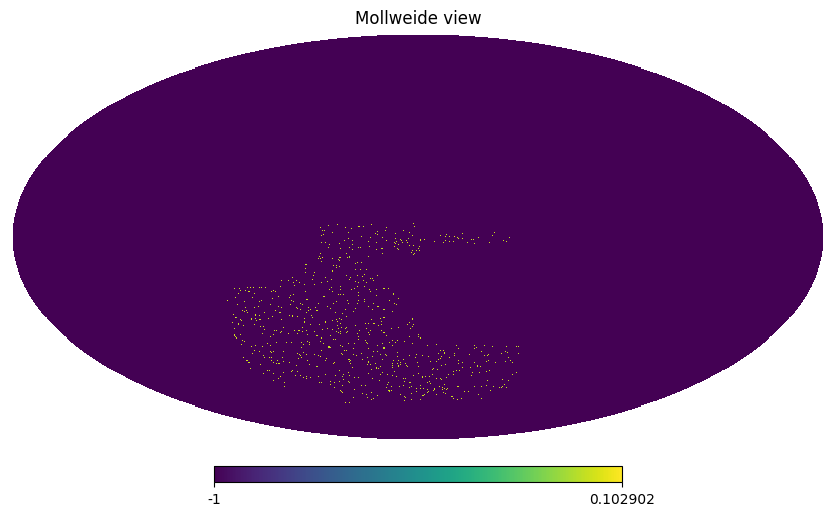

In [40]:
hp_ploc = np.zeros(hp.nside2npix(512)) - 1
hp_ploc[ploc] = pval
hp.mollview(hp_ploc, min=-1)

In [41]:
def g2k_sphere(gamma1, gamma2, mask, nside=512, lmax=2048,nosh=True):
    """
    Convert shear to convergence on a sphere. In put are all healpix maps.
    """

    gamma1_mask = gamma1 * mask
    gamma2_mask = gamma2 * mask

    KQU_masked_maps = [gamma1_mask, gamma1_mask, gamma2_mask]
    alms = hp.map2alm(KQU_masked_maps, lmax=lmax, pol=True)  # Spin transform!


    ell, emm = hp.Alm.getlm(lmax=lmax)
    if nosh:
        almsE = alms[1] * 1. * ((ell * (ell + 1.)) / ((ell + 2.) * (ell - 1))) ** 0.5
        almsB = alms[2] * 1. * ((ell * (ell + 1.)) / ((ell + 2.) * (ell - 1))) ** 0.5
    else:
        almsE = alms[1] * 1.
        almsB = alms[2] * 1. 
    almsE[ell == 0] = 0.0
    almsB[ell == 0] = 0.0
    almsE[ell == 1] = 0.0
    almsB[ell == 1] = 0.0



    almssm = [alms[0], almsE, almsB]


    kappa_map_alm = hp.alm2map(almssm[0], nside=nside, lmax=lmax, pol=False)
    E_map = hp.alm2map(almssm[1], nside=nside, lmax=lmax, pol=False)
    B_map = hp.alm2map(almssm[2], nside=nside, lmax=lmax, pol=False)

    return E_map, B_map, almsE, almsB


kmap_str = np.load("/global/cfs/cdirs/des/mgatti/Dirac_mocks/shear_maps_runsI_run086_nside512_noiserel10.npy", allow_pickle=True).item()[0][4]

In [42]:
print(kmap_str.keys())

e1 = np.zeros(hp.nside2npix(512))
e2 = np.zeros(hp.nside2npix(512))
e1[kmap_str['pix']] = kmap_str['e1']
e2[kmap_str['pix']] = kmap_str['e2']
mask_sims = np.in1d(np.arange(len(e1)),kmap_str['pix'])
f,fb,almsE,almsB = g2k_sphere(e1,e2, mask_sims)

dict_keys(['e1', 'e2', 'e1n', 'e2n', 'pix'])


/tmp/ipykernel_1669163/3578755406.py:15: RuntimeWarning: divide by zero encountered in divide
  almsE = alms[1] * 1. * ((ell * (ell + 1.)) / ((ell + 2.) * (ell - 1))) ** 0.5
/tmp/ipykernel_1669163/3578755406.py:15: RuntimeWarning: invalid value encountered in multiply
  almsE = alms[1] * 1. * ((ell * (ell + 1.)) / ((ell + 2.) * (ell - 1))) ** 0.5
/tmp/ipykernel_1669163/3578755406.py:16: RuntimeWarning: divide by zero encountered in divide
  almsB = alms[2] * 1. * ((ell * (ell + 1.)) / ((ell + 2.) * (ell - 1))) ** 0.5
/tmp/ipykernel_1669163/3578755406.py:16: RuntimeWarning: invalid value encountered in multiply
  almsB = alms[2] * 1. * ((ell * (ell + 1.)) / ((ell + 2.) * (ell - 1))) ** 0.5


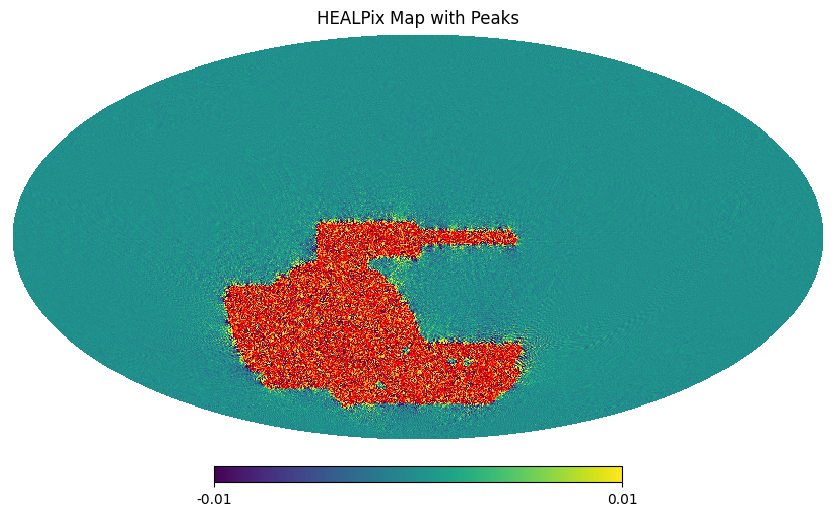

In [43]:
hp.mollview(f, title='HEALPix Map with Peaks', min=-1e-2, max=1e-2)
hp.visufunc.projscatter(hp.pix2ang(512, ploc, lonlat=True),
                        marker='x', color='red', s=0.1, coord='C', lonlat=True)

In [44]:
filter_size_arcmin = 21  # Smoothing scale in arcmin
fwhm = np.radians(filter_size_arcmin / 60)  # FWHM of the Gaussian filter in radians
f_sm = hp.sphtfunc.smoothing(f, fwhm=fwhm)

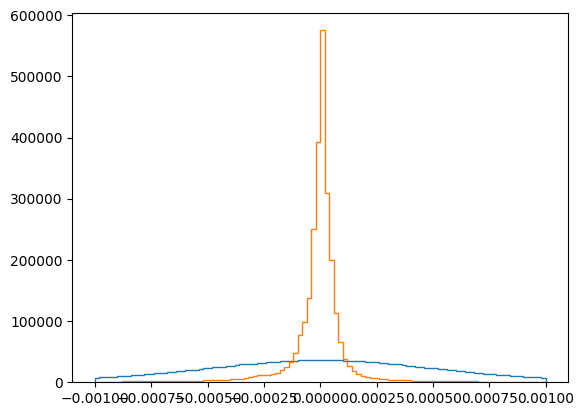

In [45]:
plt.hist(f, bins=100, range=[-1e-3, 1e-3], histtype='step')
plt.hist(f_sm, bins=100, range=[-1e-3, 1e-3], histtype='step')
plt.show()
plt.close()

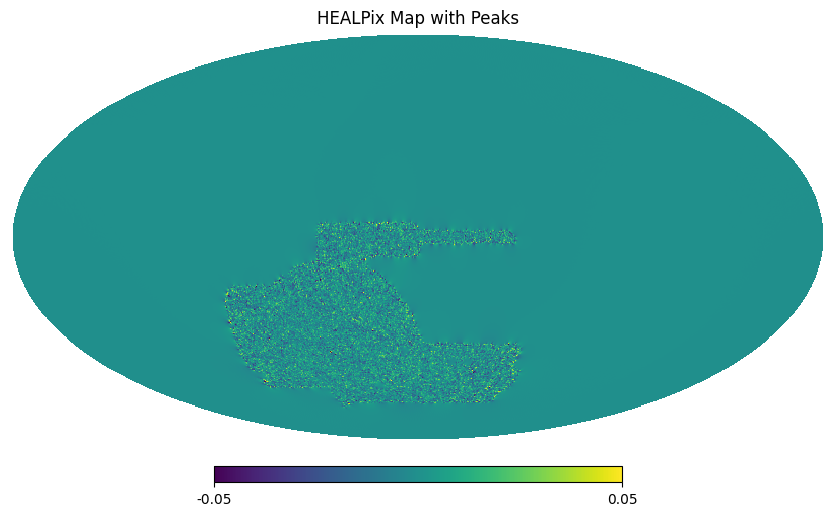

In [46]:
hp.mollview(f_sm, title='HEALPix Map with Peaks', min=-5e-2, max=5e-2)
# hp.visufunc.projscatter(hp.pix2ang(512, ploc, lonlat=True),
#                         marker='x', color='red', s=0.1, coord='C', lonlat=True)

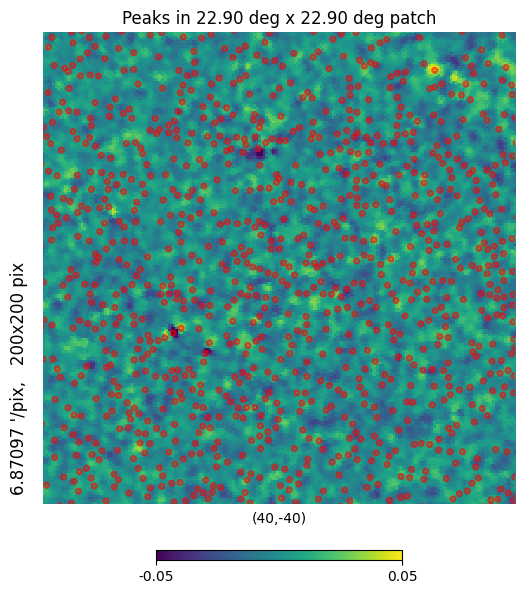

In [47]:
# Define the center of the gnomic projection
center_ra = 40.0  # Center Right Ascension in degrees
center_dec = -40.0  # Center Declination in degrees
res = hp.nside2resol(512, arcmin=True)  # Pixel resolution in arcmin

# Plotting the gnomic projection patch
hp.gnomview(f_sm, rot=(center_ra, center_dec), xsize=200, ysize=200, reso=res, \
                title=f"Peaks in {200*res/60:.2f} deg x {200*res/60:.2f} deg patch", \
                min=-5e-2, max=5e-2)

# Plotting the peaks on the gnomonic patch
lon, lat = hp.pix2ang(512, ploc, lonlat=True)
hp.projscatter(lon, lat, marker='o', color='red', facecolors='none', s=10, lw=2, alpha=0.6, lonlat=True)

plt.show()

In [ ]:
neigh_inds = hp.get_all_neighbours(512, ploc)
for p, n in zip(ploc, neigh_inds):
    print(p, n)
    print(f_sm[p], f_sm[n])
    assert np.all(f_sm[p] > f_sm[n]), f"{p}"

1424489 [1426537 1426559 1428661 ... 3016354 3017366 3019390]
0.01881400099578292 [ 0.02297496  0.0097511   0.00664984 ... -0.01537509  0.03568707
 -0.08231939]


AssertionError: 1424489

In [1]:
import networkx as nx
import torch_geometric as pyg
import torch
import numpy as np
data = torch.load("../data/20231115dirac_tomobin0_scale21.0/graphs/data0.pt")[0]

/global/cfs/cdirs/des/shubh/.conda/envs/gnn/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


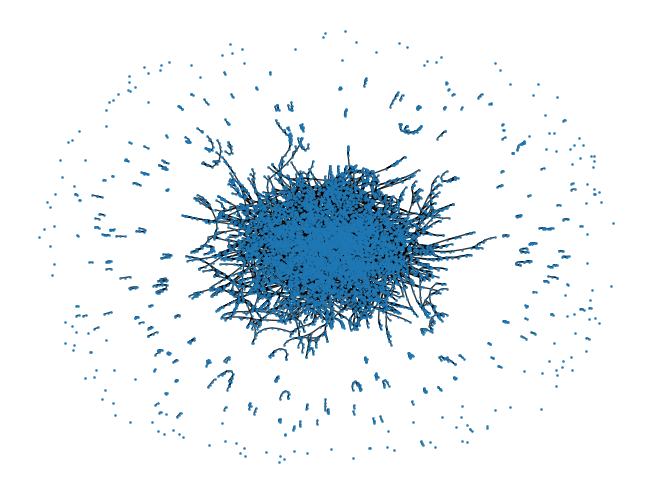

In [25]:
subset_size = len(data.x)
subgraph = pyg.utils.subgraph(list(range(0, subset_size)), data.edge_index)
subgraph = pyg.data.Data(x=data.x[:subset_size], edge_index=subgraph[0])
g = pyg.utils.to_networkx(subgraph, to_undirected=True)
nx.draw(g, node_size=1, alpha=0.8)

In [3]:
path = lambda n : f"../data/20231115dirac_tomobin0_scale21.0/graphs/data{n}.pt"
for i in range(100):
    try:
        a = torch.load(path(i))
        print(i, len(a), a[np.random.randint(0, len(a))])
    except:
        print(i, "failed")

0 491 Data(x=[10308, 1], edge_index=[2, 39664], edge_attr=[39664, 2], y=[6])
1 491 Data(x=[10979, 1], edge_index=[2, 45299], edge_attr=[45299, 2], y=[6])
2 491 Data(x=[10588, 1], edge_index=[2, 42159], edge_attr=[42159, 2], y=[6])
3 491 Data(x=[10825, 1], edge_index=[2, 44103], edge_attr=[44103, 2], y=[6])
4 491 Data(x=[10789, 1], edge_index=[2, 44290], edge_attr=[44290, 2], y=[6])
5 491 Data(x=[10695, 1], edge_index=[2, 43111], edge_attr=[43111, 2], y=[6])
6 491 Data(x=[10877, 1], edge_index=[2, 44946], edge_attr=[44946, 2], y=[6])
7 491 Data(x=[10967, 1], edge_index=[2, 45588], edge_attr=[45588, 2], y=[6])
8 491 Data(x=[10892, 1], edge_index=[2, 44787], edge_attr=[44787, 2], y=[6])
9 491 Data(x=[10946, 1], edge_index=[2, 45356], edge_attr=[45356, 2], y=[6])
10 491 Data(x=[11032, 1], edge_index=[2, 46302], edge_attr=[46302, 2], y=[6])
11 491 Data(x=[10886, 1], edge_index=[2, 44664], edge_attr=[44664, 2], y=[6])
12 491 Data(x=[10953, 1], edge_index=[2, 45491], edge_attr=[45491, 2], y=[

190